#  Measuring the Weinberg angle

By Kyle Cranmer, Lukas Heinrich, Tim Head, Gilles Louppe
(*Based on earlier work with NYU CDS masters students Manoj Kumar, Phil Yeres, and Michele Ceru and discussions with Brenden Lake and Gilles Louppe.*)

The point of this notebook is to explore the synergy of three powerful techniques:

   1. generic likelihood-free inference engines (eg. ABC, carl, etc.) that enable statistical inference on the parameters of a theory that are implicitly defined by a simulator
 
   2. workflows that encapsulate scientific pipelines and extend the scope from reproducibility to reusability
 
   1. active learning and sequential design algorithms (eg. Bayesian optimization) that balance exploration and exploitation to efficiently optimize an expensive black box objective function
 
Together, these three ideas can be combined to enable an efficient and automated loop of the scientific method -- at least, for a sufficiently well posed problem. The scientist's input to the system are:

 * an external workflow that implements some experimental protocol (orange **Exp** component)
 * an external workflow that implements a simulator for those experiments, which depends on some theoretical parameters that we would like to infer (orange **Sim** component).
 
Interesingly, we will use the simulator not only to perform inference on the parameters, but also to design the next experiment (this is where active learning comes in).

Notation:

   * $\phi$ : Parameters that specify the experimental configuration

   * $\theta$: Parameters of the theory / simulator, which we would like to infer from the experimental data

   * $X$ : Data generated from the experiment or simulator

<img src="flowchart.png" alt="flowchart" width="80%" />

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib nbagg

In [2]:
%%javascript
require.config({paths: {
        vis: "http://cdnjs.cloudflare.com/ajax/libs/vis/4.17.0/vis",
        yadage: "https://rawgit.com/cranmer/active_sciencing/yadage/yadage"
    }
});

<IPython.core.display.Javascript object>

In [3]:
import distr
import common
import plots

In [4]:
import models.model_weinberg as model

## The simulator

This is a simulation of high energy particle collisions $e^+e^- \to \mu^+ \mu^-$. The angular distributions of the particles can be used to measure the [Weinberg angle](https://en.wikipedia.org/wiki/Weinberg_angle) in the standard model of particle physics. If you get a PhD in particle physics, you may learn how to calculate these distributions and interpret those equations to learn that an effective way to infer this parameter is to run your particle accelerator with a beam energy just above or below half the $Z$ boson mass (i.e. the optimal $\phi$ is just above and below 45 GeV). 

## Step 1: Perform Experiment

User provides workflow that implements the real experiments (orange component of flowchart labeled **Exp**).

In [5]:
science_ndata = 20
science_theta_nature = 1.0

In [6]:
def collect_data(phi,ndata, widget = None):
    return model.simulator(science_theta_nature,phi,ndata, widget, delay = True)

## Step 2: Bayesian Update

We Here we use a generic simulation-based inference engine like ABC or Carl to update from prior to posterior. The user provides a workflow that implements the simulator (orange component of the flowchart labled **Sim**) and we infer the posterior probability of the parameters of the simulator given the data.

In [7]:
def calculate_posterior(prior,data,phi):
    posterior = common.calculate_posterior(
                            prior,data,phi,
                            lnprob_args = model.details_likelihood_settings,
                            n_chainlen = 50
    )
    maximum_a_post = posterior.map(model.details_map_bins)
    
    print 'Best Theta: ', maximum_a_post
    return posterior, maximum_a_post

## Step 3: Optimize Experimental Configuration

Based on the updated posterior $p(\theta)$ we will consider future experiments with configuration $\phi$. For each of those configurations, we will run several simulations of the experiment and perform inference on those simulated datasets to estimate the expected information gain (EIG)

\begin{equation}
EIG(\phi) =  \int dx d\theta \; p(x | \theta) p(\theta) \big [ H\left [P(\theta) \right] - H\left[ P(\theta\, |\, x) \right] \big ] \approx \int dx  \; p(x | \theta_{MAP}) \big [ H\left [P(\theta) \right] - H\left[ P(\theta\, |\, x) \right] \big ]
\end{equation}
where
\begin{equation}
H\left [P(\theta) \right] = \int P(\theta) \log P(\theta) d\theta 
\end{equation}

To efficiently optimize $EIG[\phi]$ we will use an active learning procedure like [Bayesian Optimization](https://scikit-optimize.github.io).



In [8]:
def design_next_experiment(prior, ax = None, fig = None, widget = None):
    eig_settings = common.eig_search_settings(model,science_ndata, widget.children[0])
    
    res_gp   = common.design_next_experiment_bayesopt(
                    prior,model.phi_range,eig_settings,
                    n_random_calls = 2,n_totalcalls = 10,
                    ax = ax, fig = fig, widget = widget.children[1]
                )
    res_next_phi = res_gp[0].x[0]
    
    print 'Next Phi: ', res_next_phi
    return res_gp,res_next_phi

In [9]:
widgets, subwidgets = common.overview_widgets(model)
widgets

<IPython.core.display.Javascript object>


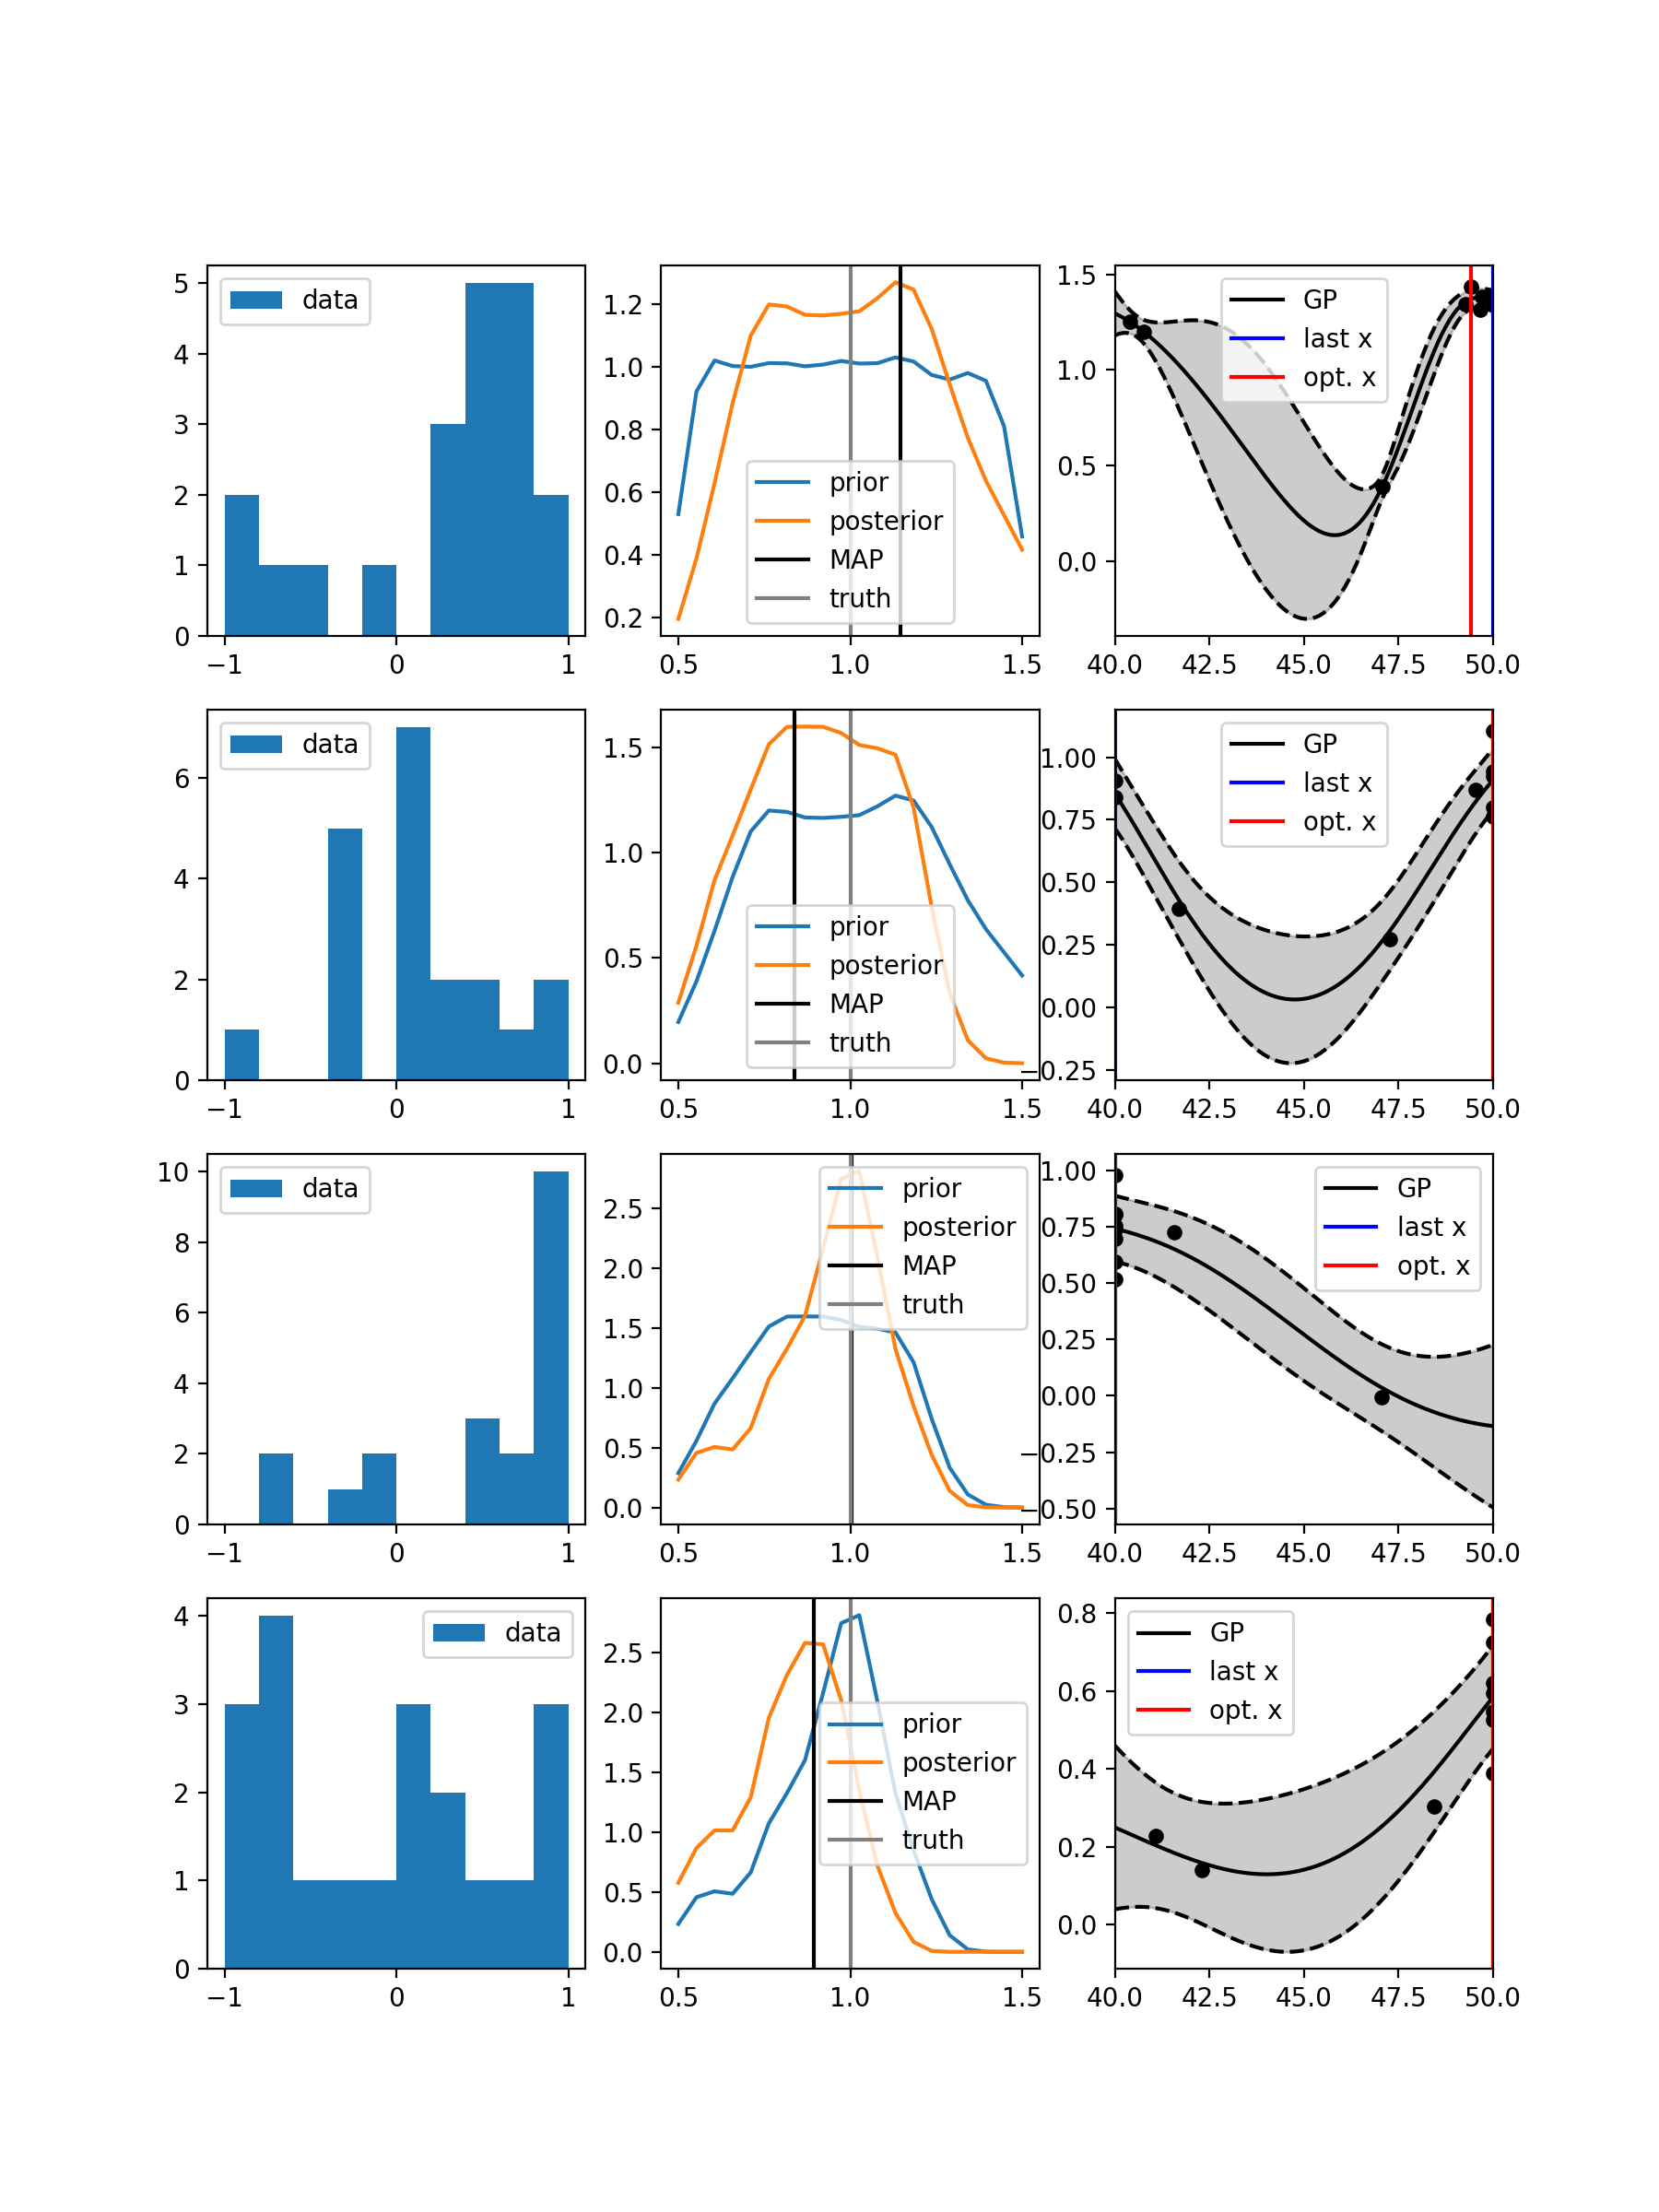

In [10]:
n_science_iterations = 4
fig,axarr = plt.subplots(n_science_iterations,3)
fig.set_size_inches(9,3*n_science_iterations)

# Running the Science Loop

In [11]:
# initial experimental settings and uninformative prior
loop_phi = 47
loop_prior = distr.Distribution('prior',range = model.theta_range)

In [12]:
science_history = []
for i in range(n_science_iterations):
        ## 1. Perform Experiment
    subwidgets[0].toggle(0)
    loop_data = collect_data(loop_phi,science_ndata, widget = subwidgets[1])
    plots.plot_data(loop_data,model.data_range, ax = axarr[i][0])
    fig.canvas.draw()

    ## 2. Calculate the Posterior
    subwidgets[0].toggle(1)
    loop_posterior, loop_best_theta = calculate_posterior(loop_prior,loop_data,loop_phi)
    plots.plot_posterior(loop_prior,loop_posterior,loop_best_theta,science_theta_nature, model.theta_range, ax = axarr[i][1])
    fig.canvas.draw()

    ## 3. Design Next Experiment
    subwidgets[0].toggle(2)
    loop_res_gp, loop_next_phi = design_next_experiment(loop_posterior,ax = axarr[i][2], fig = fig, widget = subwidgets[2])

    science_history.append([loop_data,loop_prior,loop_posterior,loop_best_theta,science_theta_nature,loop_res_gp])
    
    ## 5. Update our Prior and experimental settings
    loop_prior = loop_posterior
    loop_phi   = loop_next_phi
    time.sleep(5) # appreciate plots!

Best Theta:  1.14681157436
2017-06-10 16:02:32.280209 EIG via 4 parallel experiments with [theta,phi] 1.14681157436 40.751265008
2017-06-10 16:02:44.381697 EIG via 4 parallel experiments with [theta,phi] 1.14681157436 40.3959082113
2017-06-10 16:02:57.139281 EIG via 4 parallel experiments with [theta,phi] 1.14681157436 50.0
2017-06-10 16:03:10.383500 EIG via 4 parallel experiments with [theta,phi] 1.14681157436 47.0845588839
2017-06-10 16:03:20.575859 EIG via 4 parallel experiments with [theta,phi] 1.14681157436 49.7187504145
2017-06-10 16:03:33.389053 EIG via 4 parallel experiments with [theta,phi] 1.14681157436 49.4122831787
2017-06-10 16:03:46.396436 EIG via 4 parallel experiments with [theta,phi] 1.14681157436 49.2601337471
2017-06-10 16:03:59.422871 EIG via 4 parallel experiments with [theta,phi] 1.14681157436 49.6634474088
2017-06-10 16:04:12.432039 EIG via 4 parallel experiments with [theta,phi] 1.14681157436 50.0


/Users/cranmer/projects/gitHub/scikit-optimize/skopt/optimizer/optimizer.py:200: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2017-06-10 16:04:25.290753 EIG via 4 parallel experiments with [theta,phi] 1.14681157436 50.0
Next Phi:  49.4122831787
Best Theta:  0.838315527437
2017-06-10 16:04:55.930808 EIG via 4 parallel experiments with [theta,phi] 0.838315527437 47.2594074578
2017-06-10 16:05:05.231899 EIG via 4 parallel experiments with [theta,phi] 0.838315527437 41.6892467332
2017-06-10 16:05:15.050852 EIG via 4 parallel experiments with [theta,phi] 0.838315527437 50.0
2017-06-10 16:05:25.837497 EIG via 4 parallel experiments with [theta,phi] 0.838315527437 40.0
2017-06-10 16:05:36.471159 EIG via 4 parallel experiments with [theta,phi] 0.838315527437 49.5332170276
2017-06-10 16:05:46.879587 EIG via 4 parallel experiments with [theta,phi] 0.838315527437 50.0
2017-06-10 16:05:57.584447 EIG via 4 parallel experiments with [theta,phi] 0.838315527437 50.0
2017-06-10 16:06:08.831765 EIG via 4 parallel experiments with [theta,phi] 0.838315527437 50.0
2017-06-10 16:06:19.973561 EIG via 4 parallel experiments with [th

## A historical plot 

The plot below shows the how the expected value of a good physics feature depends on the center of mass energy (twice the beam energy). You see that there is no effect near $M_Z = 91$ GeV, but there is a big effect just above and below that value.

<img src="A_fb.png" >